In [1]:
import pandas as pd
import gurobipy as gp
import gurobipy_pandas as gppd
import numpy as np
from itertools import product, combinations, permutations
from gurobipy import GRB
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import FancyArrowPatch
import networkx as nx

In [7]:
data = pd.read_csv("assignment_files/assignment_2/Residential_areas_2.csv", header=None, names=["x", "y"])
data.head()

coordinates = {}
locations = []

for index, row in data.iterrows():
    locations.append(index)
    coordinates[index] = (row["x"], row["y"])

def manhattan_dist(loc_1, loc_2):
    l1 = coordinates[loc_1]
    l2 = coordinates[loc_2]
    return abs(l1[0] - l2[0]) + abs(l1[1] - l2[1])

distance = {(l1, l2) : manhattan_dist(l1, l2) for l1, l2 in permutations(coordinates.keys(), 2)}

n = len(locations)
print(n)

40


In [28]:
m = gp.Model()

x = m.addVars(distance.keys(), obj=distance, vtype=GRB.BINARY, name='x')
u = m.addVars(locations[1:], vtype=GRB.INTEGER, lb=1, ub=n-1, name='u')
first = locations[0]

cons_out = m.addConstrs(x.sum(i, '*') == 1 for i in locations)
cons_in = m.addConstrs(x.sum('*', i) == 1 for i in locations)

#cons_order = m.addConstrs(u[i] - u[j] + (n - 1) * x[i,j] <= n - 2 for i,j in x.keys() if i > 0 and j > 0)
cons_order = m.addConstrs(u[i] - u[j] + (n - 1) * x[i,j] + (n - 3) * x[j,i] <= n - 2 for i,j in x.keys() if i > 0 and j > 0)
cons_extra_1 = m.addConstrs(u[i] >= 1 + (n - 3) * x[i,first] + x.sum('*', i) - x[first,i] for i in u.keys())
cons_extra_2 = m.addConstrs(u[i] <= n - 1 - (n - 3) * x[first,i] + x.sum(i, '*') - x[i,first] for i in u.keys())



m.update()
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1640 rows, 1599 columns and 12168 nonzeros
Model fingerprint: 0x9cb1fc65
Variable types: 0 continuous, 1599 integer (1560 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e+00, 9e+01]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 4e+01]
Presolve time: 0.02s
Presolved: 1640 rows, 1599 columns, 9282 nonzeros
Variable types: 0 continuous, 1599 integer (1560 binary)
Found heuristic solution: objective 1440.0000000
Found heuristic solution: objective 1330.0000000

Root relaxation: objective 3.039426e+02, 225 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  303.94258    0   85 1330

In [31]:
vals = m.getAttr('x', x)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
selected

<gurobi.tuplelist (40 tuples, 2 values each):
 ( 0  , 29 )
 ( 1  , 5  )
 ( 2  , 28 )
 ( 3  , 6  )
 ( 4  , 23 )
 ( 5  , 21 )
 ( 6  , 30 )
 ( 7  , 12 )
 ( 8  , 10 )
 ( 9  , 22 )
 ( 10 , 32 )
 ( 11 , 9  )
 ( 12 , 26 )
 ( 13 , 7  )
 ( 14 , 11 )
 ( 15 , 24 )
 ( 16 , 38 )
 ( 17 , 18 )
 ( 18 , 39 )
 ( 19 , 1  )
 ( 20 , 27 )
 ( 21 , 3  )
 ( 22 , 2  )
 ( 23 , 25 )
 ( 24 , 31 )
 ( 25 , 0  )
 ( 26 , 16 )
 ( 27 , 36 )
 ( 28 , 4  )
 ( 29 , 34 )
 ( 30 , 8  )
 ( 31 , 14 )
 ( 32 , 35 )
 ( 33 , 19 )
 ( 34 , 37 )
 ( 35 , 20 )
 ( 36 , 17 )
 ( 37 , 33 )
 ( 38 , 15 )
 ( 39 , 13 )
>

formulation 2


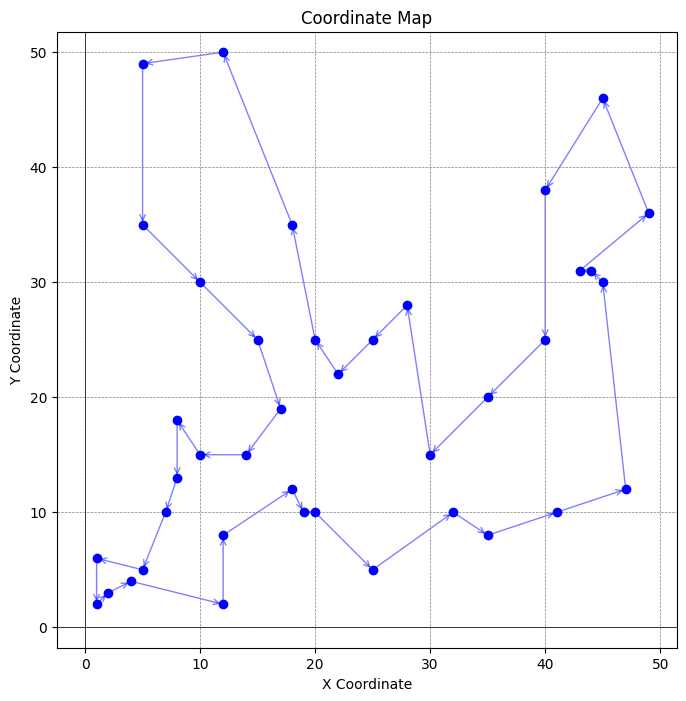

In [33]:
plt.figure(figsize=(8, 8))
for arc in selected:
    x_from, y_from = coordinates[arc[0]]
    x_to, y_to = coordinates[arc[1]]
    plt.plot(x_from, y_from, 'bo')
    arrow = FancyArrowPatch((x_from, y_from), (x_to, y_to), arrowstyle='->', color='blue', linewidth=1, mutation_scale=10, alpha=0.5)
    plt.gca().add_patch(arrow)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Coordinate Map')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
#plt.legend()
plt.axis('equal')
print("formulation 2")


In [ ]:
unvisited = locations.keys()
tour = []
while unvisited:
    current = unvisited.pop()
    tour.append(current)
    neighbors = 